# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels
import statsmodels.api as smf
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv("C:/Users/Dina/Downloads/assignment-5-main/assignment-5-main/data/tidal_wetland_estuaries.csv")
df = df.replace(-9999, np.NaN)
df.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421.0,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792.0,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268.0,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858.0,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644.0,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


In [3]:
df_east = df.loc[(df['coast']=="EAST"),:]
df_west = df.loc[(df['coast']=="WEST"),:]
stats.ttest_ind(df_east['soc_density'], df_west['soc_density'], alternative='two-sided', nan_policy='omit')

Ttest_indResult(statistic=8.45031778669312, pvalue=1.1530568956025485e-12)

I used the 2-sample t-test because we are asked to compare values between two separate groups. A 1-sample t-test wouldn't be appropriate because we're not testing if a mean of one sample is different from a set value. A paired sample t-test wouldn't be appropriate because we aren't comparing the two different measurements for one variable. 

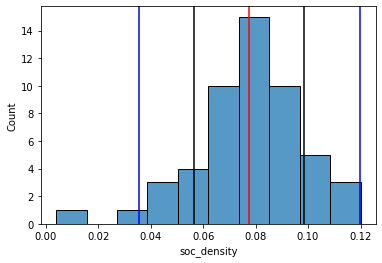

In [4]:
east = df_east['soc_density']
mean_east = np.mean(east)
std_east = np.std(east)
sns.histplot(east)
plt.axvline(x=mean_east, color="red")
plt.axvline(x=mean_east-std_east, color="black")
plt.axvline(x=mean_east+std_east, color="black")
plt.axvline(x=mean_east-2*std_east, color="blue")
plt.axvline(x=mean_east+2*std_east, color="blue")
plt.show()

This spread meets the requirement for normal data because it's in a bell shaped curve, about ⅔ of data is found within ±1 standard deviation of the mean, and  about 95% of the data is found within ±2 standard deviations.

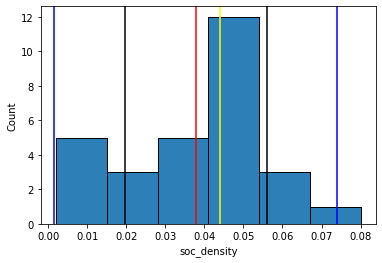

In [5]:
west = df_west['soc_density']
sns.histplot(west)
mean_west = np.mean(west)
median_west = np.median(west)
std_west = np.std(west)
sns.histplot(west)
plt.axvline(x=mean_west, color="red")
plt.axvline(x = median_west, color = "yellow")
plt.axvline(x=mean_west-std_west, color="black")
plt.axvline(x=mean_west+std_west, color="black")
plt.axvline(x=mean_west-2*std_west, color="blue")
plt.axvline(x=mean_west+2*std_west, color="blue")
plt.show()

This spread also meets the requirement for normal data. Though it doesn't have a great bell shape, the data is centered around a central measure of the median. About 2/3 of the data is found within one standard deviation of the mean and about 95% of data is found within two standard deviations of the mean. 

In [6]:
df.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421.0,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792.0,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268.0,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858.0,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644.0,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     Q('ocean_salinity_mean')   R-squared:                       0.865
Model:                                  OLS   Adj. R-squared:                  0.862
Method:                       Least Squares   F-statistic:                     235.4
Date:                      Thu, 27 Apr 2023   Prob (F-statistic):           1.04e-47
Time:                              09:20:18   Log-Likelihood:                -103.10
No. Observations:                       114   AIC:                             214.2
Df Residuals:                           110   BIC:                             225.1
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.0827      0.193    192.160      0.000      36.700      37.465
mean_precip           -0.0005      0.000     -4.192      0.000      -0.001      -0.000
tide_flow          -8.385e-11   2.92e-11     -2.867      0.005   -1.42e-10   -2.59e-11
ocean_diss_inorg_p    -7.9732      0.340    -23.444      0.000      -8.647      -7.299
==============================================================================
Omnibus:                        0.925   Durbin-Watson:                   0.357
Prob(Omnibus):                  0.630   Jarque-Bera (JB):                0.592
Skew:                           0.163   Prob(JB):                        0.744
Kurtosis:                       3.137   Cond. No.                     1.37e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

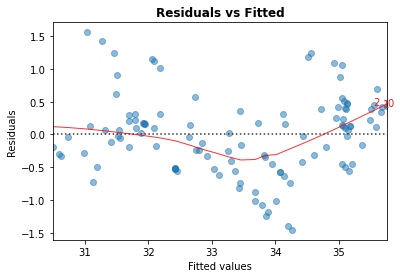

In [7]:
from utils import Linear_Reg_Diagnostic # do not change!

model = smf.ols(formula = "Q('ocean_salinity_mean') ~  mean_precip + tide_flow + ocean_diss_inorg_p", data = df).fit()
diagnostics = Linear_Reg_Diagnostic(model)
diagnostics.residual_plot();
model.summary()

In [8]:
diagnostics.vif_table()

             Features  VIF Factor
2           tide_flow        1.03
1         mean_precip        1.08
3  ocean_diss_inorg_p        1.10
0           Intercept       11.46


The adjusted R-squared value is .862. As this value is relatively high, (looking at it in the context of a 0-1 scale), it indicates that the model I generated fits the data well. Since the p values for all the coefficients are below .05, we can reject the null hypothesis. These p values indicate that the best estimates of the coefficients are the estimates generated by this model.  

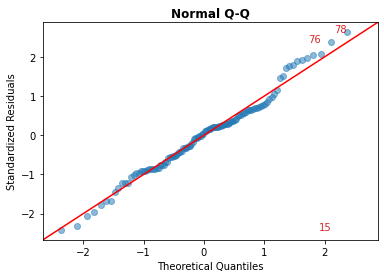

In [9]:
diagnostics.qq_plot();

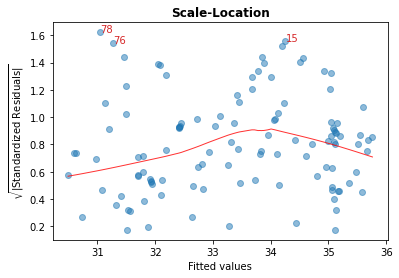

In [10]:
diagnostics.scale_location_plot();

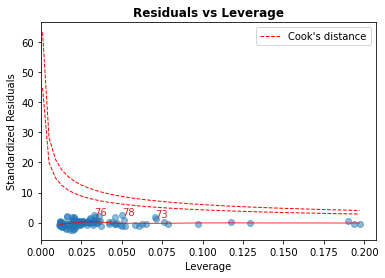

In [11]:
diagnostics.leverage_plot();

The diagnostic plots above all ensure that the data meets the assumptions of linear regerssion. 

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)

In [12]:
df2 = pd.read_csv("C:/Users/Dina/Downloads/assignment-5-main/assignment-5-main/data/coal-production.csv")

df2.head()

,year,electricity_prod
0,1960,45.904345
1,1961,45.730794
2,1962,46.411172
3,1963,46.599523
4,1964,46.102588


In [13]:
df2['year'] = pd.to_datetime(df2['year'], format='%Y')
df_coal = df2.set_index('year').sort_index()
df_coal.head()

#for ARIMA need to do the installation from class

,electricity_prod
year,
1960-01-01,45.904345
1961-01-01,45.730794
1962-01-01,46.411172
1963-01-01,46.599523
1964-01-01,46.102588


Text(0, 0.5, 'Percent Electricity Produced by Coal')

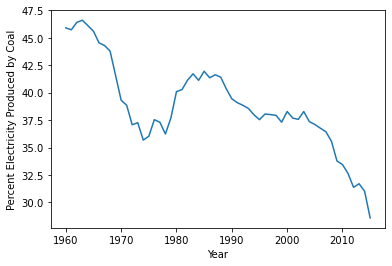

In [14]:
fig, ax = plt.subplots()
ax.plot(df_coal['electricity_prod']);
ax.set_xlabel('Year')
ax.set_ylabel('Percent Electricity Produced by Coal') #what are the units supposed to be here


The data seems to have an overall downward trend, though it's not linear. 

In [15]:
from statsmodels.tsa.stattools import adfuller

adfuller(df_coal)

def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(df_coal)

ADF Statistic: 1.8721544326758233
p-value: 0.9984818799941668


Since the p value is large, that means we must accept the null hypothesis that the time series isn't stationary. 

In [16]:
from statsmodels.tsa.arima.model import ARIMA

model1 = ARIMA(df_coal, order=(1,1,1)).fit()

c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [17]:
# print(model1.mse)
# print(model1.aic)
# print(model1.bic)

ar = list(range(6))
i = list(range(6))
ma = list(range(6))

scores = {
    'combo':[],
    'aic':[]
}

for p in ar:
    for d in i:
        for q in ma:
            
            combo = str(p) + ','  + str(d) + ',' + str(q) 
            
            aic = ARIMA(df_coal, order = (p,d,q)).fit().aic
            
            scores['combo'].append(combo)
            scores['aic'].append(aic)

scores_df = pd.DataFrame(scores)

c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN w

In [18]:
scores_df.sort_values('aic')

,combo,aic
82,"2,1,4",139.153740
83,"2,1,5",140.296981
153,"4,1,3",141.182711
45,"1,1,3",142.160087
154,"4,1,4",142.335982
...,...,...
24,"0,4,0",275.011755
31,"0,5,1",276.701889
66,"1,5,0",296.212753
0,"0,0,0",318.556416


The model above was found to be the best due to the results of the test run above.

c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
c:\Users\Dina\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


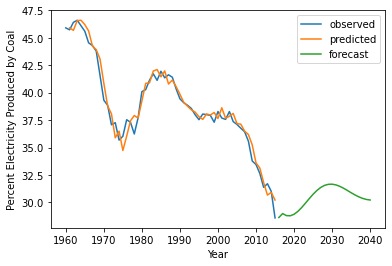

In [19]:
arima_model = ARIMA(df_coal, order = (2, 1, 4)).fit()
arima_forecast = arima_model.forecast(25)

fig, ax = plt.subplots()

ax.plot(df_coal, label='observed')
ax.plot(arima_model.predict()[1:], label='predicted')
ax.plot(arima_forecast, label='forecast')
ax.set_xlabel('Year')
ax.set_ylabel('Percent Electricity Produced by Coal')
ax.legend();